# 自己回帰型モデル


**本章で使用するデータ**  

- [AirPassengers.csv](data/AirPassengers.csv)

- [米国_個人消費支出.xlsx](data/米国_個人消費支出.xlsx)

---

## statsmodels の更新

In [1]:
# # statsmodels の更新（コメントアウトを外して実行してください）
# !pip uninstall -q statsmodels
# !pip install -q statsmodels==0.13.1

`Proceed (y/n)?` が表示されましたら `y` と入力して Enter キーを押してください。


## データの読み込み

In [2]:
# 必要なモジュール・パッケージのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
import statsmodels.api as sm

# 警告非表示
import warnings
warnings.filterwarnings('ignore')

# グラフサイズの設定
plt.rcParams['figure.figsize'] = 10, 6

時系列モデルの実装には statsmodels を使用します。statsmodels はバージョンにより実装内容が大きく変わる（使用できる関数が違う等）ため、以下のバージョンと同じかどうか確認をしておきましょう。  

詳しい実装内容に関しては[公式ドキュメント](https://www.statsmodels.org/v0.13.0/)を参照してください。  

In [3]:
# バージョンの確認
statsmodels.__version__

'0.13.2'

In [4]:
# AirPassengers.csv
df = pd.read_csv('data/AirPassengers.csv',
                 index_col='Month',
                 parse_dates=True)
df.head(3)

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132

## 時系列モデルの概要

時系列モデルの概要についてお伝えします。まずは以下の表をご覧ください。  

| 分類 | 具体的な手法 | 対応しているデータ |
| --- | --- | --- |
| 自己回帰型モデル| AR モデル | 定常過程 |
|  | MA モデル | 定常過程 |
|  | ARMA モデル | 定常過程 |
|  | ARIMA モデル | 非定常過程 |
|  | SARIMA モデル | 非定常過程 |
|  | SARIMAX モデル | 非定常過程 |
| 状態空間モデル | 線形ガウス状態空間モデル | 非定常過程 |
|  | 隠れマルコフモデル | 非定常過程 |
| 深層学習ベース | LSTM を用いた時系列モデル | 非定常過程 |
|  | Attention を用いた時系列モデル | 非定常過程 |

時系列解析を行うためのモデルは様々な種類が存在します。大きく統計モデル（自己回帰型モデル、状態空間モデル）と深層学習ベースのモデルに分類できます。  

本研修では統計モデルである自己回帰型モデルについて扱います。まずは概要を掴んでおきましょう。  

### 自己回帰型モデル

自己回帰型モデルとは**過去の自分自身の値やノイズが現在の値に影響を与えている**という考え方から定義されるモデルです。  

**例**  
$$
現在の売上高= 100000 + 0.8\times 1 日前の売上高 + 1.2\times 1 日前のノイズ
$$

過去のどの値を考慮するのかやどんなデータに対して適用するかにより様々なモデルがありますが、構造自体は過去のデータから現在を予測するというシンプルな内容です。  

この後は自己回帰型モデルの各手法について詳細に見ていきます。

## AR モデル : 自己回帰モデル : autoregressive model



**過去の自分のデータを使って短期の自己相関を表現するモデル** です。  

**1 次の AR モデル (AR(1))**

$$
\rm y_{t} = C + \phi_{1}y_{t-1} + \epsilon_{t}
$$

- $\rm y_{t}$：時点 $\rm t$ の時系列
- $\rm C$：定数項
- $\rm \phi_{1}$：パラメータ
- $\rm \epsilon_{t}$：時点 $\rm t$ でのホワイトノイズ $\rm:(\epsilon_{t}\sim N(0, \sigma^2))$


例：今月の飛行機の乗客数を予測する AR モデル

$$
\rm y_{t} = 100 + 0.8\times y_{t-1} + \epsilon_{t}
$$

- 0.8 : 推定されたパラメータ（最尤法）
- $\rm y_{t-1}$：先月の乗客数
- $\rm \epsilon_{t}$：今月のホワイトノイズ

次数を増やすことも可能です。  

**3 次の AR モデル (AR(3))**

$$
\rm y_{t} = 100 + 0.8\times y_{t-1}+0.6\times y_{t-2}+0.4\times y_{t-3}+\epsilon_{t}
$$

- $\rm y_{t-1}$：先月の乗客数
- $\rm y_{t-2}$：2 ヶ月前の乗客数
- $\rm y_{t-3}$：3 ヶ月前の乗客数
- $\rm \epsilon_{t}$：今月のホワイトノイズ

サンプルデータを作成し、AR モデルを適用させてみましょう。  

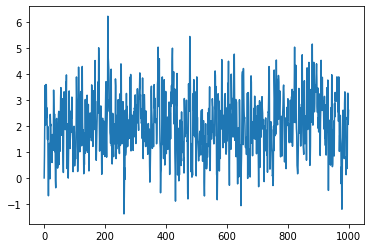

In [5]:
# AR モデル用のサンプルデータ
np.random.seed(42) # シードの固定
y = np.zeros(1000)
epsilon = np.random.randn(1000)  # 標準正規分布

# サンプルデータの作成
for t in range(1, 1000):
    y[t] = 1 + 0.5 * y[t - 1] + epsilon[t]

# Series 型に変換
y = pd.Series(y)

# 可視化
plt.plot(y);

それでは AR モデルの実装を行います。実装は `statsmodels.tsa.arima.model.ARIMA()` クラスで実装できます。正確にはこちらは後述する SARIMAX モデルの実装なのですが引数で AR モデルとしても使用できるためこちらで実装を行います。  

`order` の引数で AR モデルの次数（何日前までのデータを考慮したモデルにするか）を決定します。詳細は以下です。  

- order=(p, d, q)
  - p : AR モデルの次数
  - d : ARIMA モデルにおいて差分を取る階数（後述）
  - q : MA モデルの次数（後述）

In [6]:
# AR モデルでフィッティング
from statsmodels.tsa import arima
ar_model = arima.model.ARIMA(y, order=(1, 0, 0)).fit()
print(ar_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1399.053
Date:                Fri, 30 Sep 2022   AIC                           2804.106
Time:                        00:37:29   BIC                           2818.829
Sample:                             0   HQIC                          2809.702
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0316      0.061     33.167      0.000       1.912       2.152
ar.L1          0.4938      0.028     17.434      0.000       0.438       0.549
sigma2         0.9607      0.042     22.616      0.0

上記がデータを学習させた結果になります。様々な情報が出ていますが、まずは以下を確認しましょう。  

- const : 定数項 ($C$)
- ar.L1 : 時点 $t-1$ における時系列の係数であるパラメータ ($\phi_{1}$)
- sigma2 : 残差であるホワイトノイズ項の分散 ($\sigma^2$)

残差の定義は以下です。  

- 残差 = 実測値 - 推定したモデルの予測値  

また

- coef : 推定量
- std err : 標準誤差（推定量の標準偏差）

となります。  

それでは適切なモデリングができたか確認します。**モデルの妥当性が認められる場合には、残差はホワイトノイズ**となるため、以下が満たされます。  

- 残差項の分布が正規分布になっているか
- 自己相関がすべて 0 に近いか（95% 信頼区間にすべて含まれるか）

本章では自己相関のみ確認してみます。  

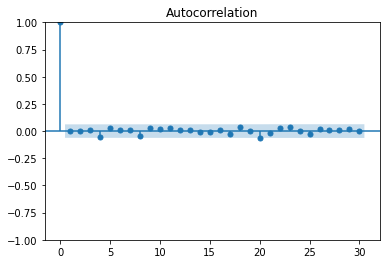

In [7]:
# 残差チェック
sm.graphics.tsa.plot_acf(ar_model.resid, lags=30)
plt.show()

ラグ 0 以外のすべての自己相関係数が 95%信頼区間に含まれているため、適切なモデリングができていそうです。  

最後にモデルに予測をさせ、原系列と予測結果の比較を行いましょう。  

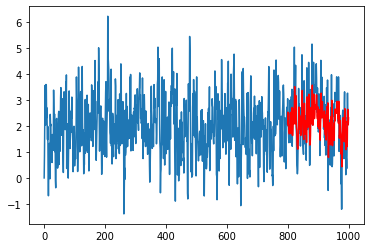

In [8]:
# 予測
pred = ar_model.predict(start=800, end=1000)
# 原系列
plt.plot(y)
# 予測
plt.plot(pred, color='red');

傾向はあっていますが、値の散らばり具合が少し異なることが確認できました。  

## MA モデル : 移動平均モデル : moving average model

**過去のホワイトノイズを用いて短期の自己相関を表現する** モデルです。

**1 次の MA モデル (MA(1))**

$$
\rm y_{t} = \mu + \theta_{1}\epsilon_{t-1} + \epsilon_{t}
$$

- $\rm \mu$：定数項
- $\rm \theta_{1}$：パラメータ
- $\rm \epsilon_{t}$：時点 $\rm t$ での正規ホワイトノイズ $\rm:(\epsilon_{t}\sim N(0, \sigma^2))$

AR モデルと同様に実装してみましょう。  

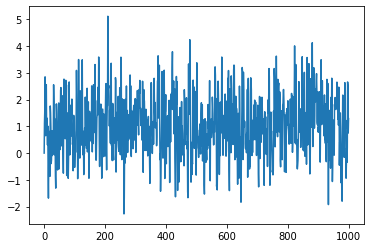

In [9]:
#プロットするデータ列の作成
y = np.zeros(1000)
np.random.seed(42)
epsilon = np.random.randn(1000)  # 標準正規分布

for t in range(1, 1000):
    y[t] = 1 + 0.5 * epsilon[t - 1] + epsilon[t]

y = pd.Series(y)
plt.plot(y);

MA モデルを実装する際は `order=(p, d, q)` の `q` にて MA モデルの次数を決定します。  

In [10]:
# MA モデルでフィッティング
ma_model = arima.model.ARIMA(y, order=(0, 0, 1)).fit()
print(ma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -1398.099
Date:                Fri, 30 Sep 2022   AIC                           2802.198
Time:                        00:37:29   BIC                           2816.921
Sample:                             0   HQIC                          2807.794
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0269      0.047     21.987      0.000       0.935       1.118
ma.L1          0.5034      0.028     18.279      0.000       0.449       0.557
sigma2         0.9589      0.042     22.586      0.0

上記の結果となりました。作成したサンプルの値をうまく推定できています。  

それでは残差の確認も行いましょう。  

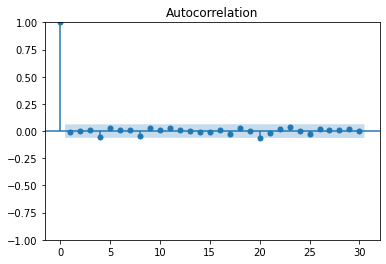

In [11]:
# 残差チェック
sm.graphics.tsa.plot_acf(ma_model.resid, lags=30)
plt.show()

少々 95% 信頼区間を外れているものもありますが、ほとんどのラグは区間内に含まれています。  

最後に予測結果の確認も行いましょう。  

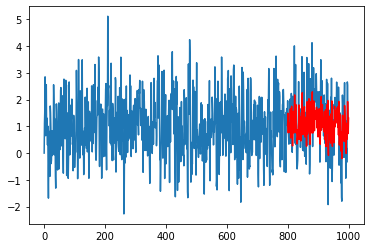

In [12]:
# 予測
pred = ma_model.predict(start=800, end=1000)
# 原系列
plt.plot(y)
# 予測
plt.plot(pred, color='red');

こちらも AR モデルと同様にデータの散らばり具合のみうまく予測できていないようです。




## ARMA モデル : 自己回帰移動平均モデル : autoregressive moving average model



名前の通り AR + MA のモデルです。

**1 次の ARMA モデル (ARMA(1, 1))**

$$
\rm y_{t} = 100 + 0.8\times y_{t-1}+0.6\times \epsilon_{t-1}+\epsilon_{t}
$$

- $\rm y_{t}$：今月の乗客数
- 0.8：推定された AR のパラメータ
- $\rm y_{t-1}$：先月の乗客数
- 0.6：推定された MA のパラメータ
- $\rm \epsilon_{t-1}$：先月のホワイトノイズ
- $\rm \epsilon_{t}$：今月の正規ホワイトノイズ $\rm:(\epsilon_{t}\sim N(0, \sigma^2))$

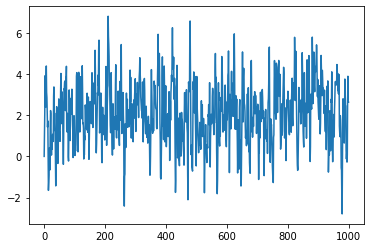

In [13]:
#プロットするデータ列の作成
y = np.zeros(1000)
np.random.seed(42)
epsilon = np.random.randn(1000) # 標準正規分布

for t in range(1,1000):
    y[t] = 1 +  0.5 * y[t-1] + 0.5 * epsilon[t-1] + epsilon[t]
y = pd.Series(y)
plt.plot(y);

`order=(p, d, q)` では、AR モデルと MA モデルの次数である `p` と `q` を指定します。  

In [14]:
# ARMA モデルでフィッティング
arma_model = arima.model.ARIMA(y, order=(1, 0, 1)).fit()
print(arma_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1398.875
Date:                Fri, 30 Sep 2022   AIC                           2805.751
Time:                        00:37:30   BIC                           2825.382
Sample:                             0   HQIC                          2813.212
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.0498      0.091     22.470      0.000       1.871       2.229
ar.L1          0.4851      0.036     13.325      0.000       0.414       0.556
ma.L1          0.5136      0.035     14.679      0.0

適切にモデリングができているか、残差のチェックも行いましょう。

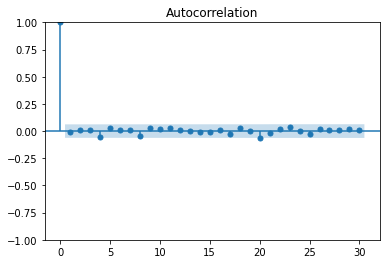

In [15]:
# 残差チェック
sm.graphics.tsa.plot_acf(arma_model.resid, lags=30)
plt.show()

予測結果も確認しましょう。

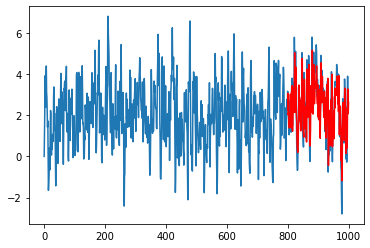

In [16]:
# 予測
pred = arma_model.predict(start=800, end=1000)
# 原系列
plt.plot(y)
# 予測
plt.plot(pred, color='red');

上記を見ると、AR モデルや MA モデルよりも比較的うまく予測できていることがわかりました。  



## ARIMA モデル : 自己回帰和分移動平均モデル : autoregressive integrated moving average model



データの差分を取ってから ARMA モデルを適用したモデルです。差分をとることにより、**非定常過程のデータ（扱いにくいデータ）を定常過程（扱いやすいデータ）に変換**できます。  

**次数の読み方**

$$
\rm ARIMA(p, d, q)
$$

と表記します。

$$
\rm ARIMA(3, 1, 2)
$$

- `AR (3)`：1~3 時点前の「自分のデータ」を使用
- `I (1)`：データの 1 階差分を取る
- `MA (2)`：1~2 時点前の「ホワイトノイズ」を使用

こちらは AirPassengers.csv を使用して実装します。

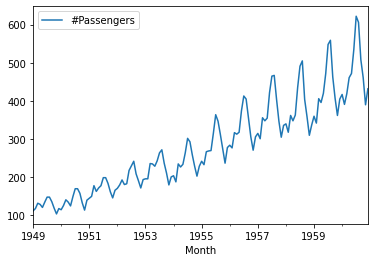

In [17]:
# データのプロット
df.plot();

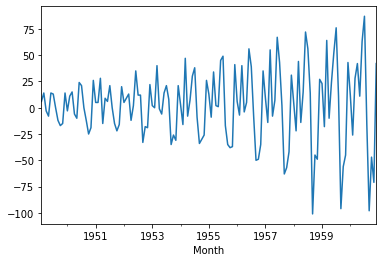

In [18]:
# 1 階差分のプロットも確認しておく
df['#Passengers'].diff().dropna().plot();

それでは ARIMA モデルを適用してみます。今回の次数は決め打ちで `order=(1, 1, 1)` と設定します。  

In [19]:
# ARIMA モデルでフィッティング
arima_model = arima.model.ARIMA(df['#Passengers'], order=(1, 1, 1)).fit()
print(arima_model.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -694.341
Date:                Fri, 30 Sep 2022   AIC                           1394.683
Time:                        00:37:30   BIC                           1403.571
Sample:                    01-01-1949   HQIC                          1398.294
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4742      0.123     -3.847      0.000      -0.716      -0.233
ma.L1          0.8635      0.078     11.051      0.000       0.710       1.017
sigma2       961.9270    107.433      8.954      0.0

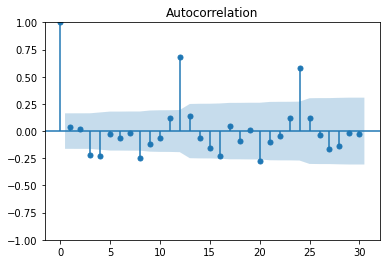

In [20]:
# 残差チェック
sm.graphics.tsa.plot_acf(arima_model.resid, lags=30)
plt.show()

季節性が残っているため、うまくモデリングできていないことが確認できます。

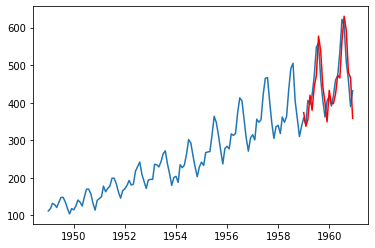

In [21]:
# 予測
pred = arima_model.predict(start='1959-01-01', end='1960-12-01')
# 原系列
plt.plot(df['#Passengers'])
# 予測
plt.plot(pred, color='red');

予測結果はだいたいあっていますが、少しずれていることが確認できます。

## SARIMA モデル : 季節変動自己回帰和分移動平均モデル : seasonal autoregressive integrated moving average model


ARIMA モデルに周期性を取り入れたモデルです。

**次数の読み方**

$$
\rm SARIMA(p, d, q)(P, D, Q)[S]
$$

と表記します。また具体例として  

$$
\rm SARIMA(3, 1, 2)(2, 1, 1)[12]
$$

上記のような 12 の区間で周期性を持つデータを考えます。  

| 年 | 1 月 | 2 月 | ・・・ | 12 月 |
| --- | --- | --- | --- | --- |
| 2019 | 320 | 520 | ・・・ | 430 |
| 2020 | 423 | 670 | ・・・ | 512 |
| 2021 | 543 | 598 | ・・・ | 621 |

- `ARIMA (3, 1, 2)`：横方向（2019 年の 1 月 ~ 12 月など）のデータに対する ARIMA の次数
- `S (2, 1, 1)`：縦方向（2019 年の 1 月、2020 年の 1 月、2021 年の 1 月）のデータに対する ARIMA の次数
- `[12]`：周期の長さ指定
    - 12 ヶ月で 1 周期：12
    - 7 日間で 1 週間の周期：7

今回も ARIMA と同様に次数は決め打ちで設定します。

In [22]:
# SARIMA モデルでフィッティング
sarima_model = arima.model.ARIMA(df['#Passengers'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
print(sarima_model.summary())

                                    SARIMAX Results                                     
Dep. Variable:                      #Passengers   No. Observations:                  144
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.149
Date:                          Fri, 30 Sep 2022   AIC                           1022.299
Time:                                  00:37:31   BIC                           1036.675
Sample:                              01-01-1949   HQIC                          1028.140
                                   - 12-01-1960                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1272      0.356     -0.358      0.721      -0.825       0.570
ma.L1         -0.2148      0.325     -0.660      0.

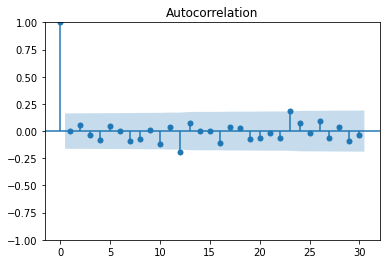

In [23]:
# 残差チェック
sm.graphics.tsa.plot_acf(sarima_model.resid, lags=30)
plt.show()

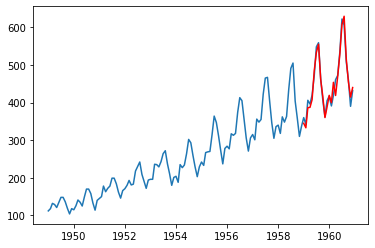

In [24]:
# 予測
pred = sarima_model.predict(start='1959-01-01', end='1960-12-01')
# 原系列
plt.plot(df['#Passengers'])
# 予測
plt.plot(pred, color='red');

きれいに予測出来ていることが確認できました。

## SARIMAX モデル : 季節自己回帰和分移動平均モデル + 外生変数 : seasonal autoregressive integrated moving average model + exogeneous variables



SARIMAX モデルは SARIMA モデルに外生変数を考慮させたモデルです。主に**外因性を考慮させたモデル**になります。外生変数を組み込むイメージとしては以下です。  

**1 次の ARMA モデル (ARMA(1, 1)) に組み込む場合**

$$
\rm y_{t} = 100 + 0.8\times y_{t-1}+0.6\times \epsilon_{t-1}+ 10\times x_{t} +\epsilon_{t}
$$

- $\rm y_{t}$：今月の乗客数
- 0.8：推定された AR のパラメータ
- $\rm y_{t-1}$：先月の乗客数
- 0.6：推定された MA のパラメータ
- $\rm \epsilon_{t-1}$：先月のホワイトノイズ
- 10：推定された外生変数のパラメータ
- $x_{t}$：今月のイベント状況（外生変数）
- $\rm \epsilon_{t}$：今月の正規ホワイトノイズ $\rm:(\epsilon_{t}\sim N(0, \sigma^2))$

外生変数を考慮することにより、自身の値以外の要素もモデルに組み込むことができます。  

今回は飛行機の乗客数のデータを STL 分解した時の季節指数を外生変数として考慮させてみます。  

In [25]:
# STL 分解
decomposition = sm.tsa.seasonal_decompose(df, model='multiplicative')
# 直近の季節指数を取得
seasonal_index = decomposition.seasonal[-12:].to_frame()
# 月のデータを格納
seasonal_index['month'] = pd.to_datetime(seasonal_index.index).month
seasonal_index.head(3)

seasonal  month
Month                      
1960-01-01  0.910230      1
1960-02-01  0.883625      2
1960-03-01  1.007366      3

それでは、原系列のデータフレームと季節指数のデータフレームを結合します。

In [26]:
# 原系列のデータフレームに月のデータを格納
df['month'] = df.index.month
# 月のデータを参照してデータを結合
df_merge = pd.merge(df, seasonal_index, how='left', on='month')
# カラム名を変更
df_merge.columns = ['value', 'month', 'seasonal_index']
# インデックスを元に戻す
df_merge.index = df.index

In [27]:
df_merge.head(13)

value  month  seasonal_index
Month                                   
1949-01-01    112      1        0.910230
1949-02-01    118      2        0.883625
1949-03-01    132      3        1.007366
1949-04-01    129      4        0.975906
1949-05-01    121      5        0.981378
1949-06-01    135      6        1.112776
1949-07-01    148      7        1.226556
1949-08-01    148      8        1.219911
1949-09-01    136      9        1.060492
1949-10-01    119     10        0.921757
1949-11-01    104     11        0.801178
1949-12-01    118     12        0.898824
1950-01-01    115      1        0.910230

外生変数の準備ができましたので、SARIMAX モデルを構築してみましょう。  

In [28]:
# SARIMA モデルでフィッティング
sarimax_model = arima.model.ARIMA(endog=df_merge['value'], # 時系列
                                  exog=df_merge['seasonal_index'],  # 外生変数
                                  order=(1, 1, 1),
                                  seasonal_order=(1, 1, 1, 12)).fit()
print(sarimax_model.summary())

                                    SARIMAX Results                                     
Dep. Variable:                            value   No. Observations:                  144
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -506.149
Date:                          Fri, 30 Sep 2022   AIC                           1024.299
Time:                                  00:37:31   BIC                           1041.550
Sample:                              01-01-1949   HQIC                          1031.309
                                   - 12-01-1960                                         
Covariance Type:                            opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
seasonal_index -1.244e-05   3.93e+04  -3.17e-10      1.000    -7.7e+04     7.7e+04
ar.L1             -0.1272      0.357   

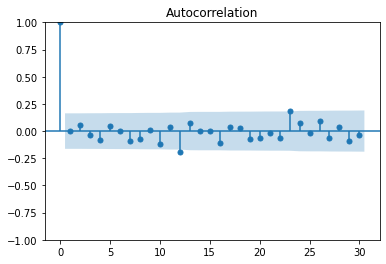

In [29]:
# 残差チェック
sm.graphics.tsa.plot_acf(sarimax_model.resid, lags=30)
plt.show()

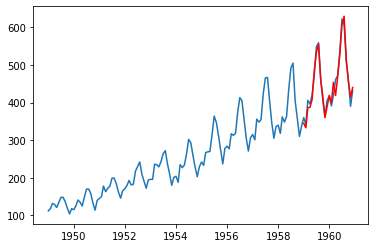

In [30]:
# 予測
pred = sarimax_model.predict(start='1959-01-01', end='1960-12-01')
# 原系列
plt.plot(df_merge['value'])
# 予測
plt.plot(pred, color='red');

今回はもともとの予測精度が高かっため、あまり変化は見られませんでした。

## ワーク
### ワーク 1
Github レポジトリ (https://github.com/owid/covid-19-data/tree/master/public/data) にあるコロナウイルスに関するデータを使用して時系列解析を行ってください。

データセットの各カラムに関する詳細はこちら(https://github.com/owid/covid-19-data/tree/master/public/data#the-complete-our-world-in-data-covid-19-dataset)を参照してください。

本の新規感染者数を予測できるモデルを作成してください。
データを読み込むコードは以下を参考にしてください。

In [31]:
# パスの指定
import pandas as pd
path = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
# データの読み込み
df = pd.read_csv(path, index_col='date', parse_dates=True)
df.head(3)

iso_code continent     location  total_cases  new_cases  \
date                                                                 
2020-02-24      AFG      Asia  Afghanistan          5.0        5.0   
2020-02-25      AFG      Asia  Afghanistan          5.0        0.0   
2020-02-26      AFG      Asia  Afghanistan          5.0        0.0   

            new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  \
date                                                                            
2020-02-24                 NaN           NaN         NaN                  NaN   
2020-02-25                 NaN           NaN         NaN                  NaN   
2020-02-26                 NaN           NaN         NaN                  NaN   

            total_cases_per_million  ...  female_smokers  male_smokers  \
date                                 ...                                 
2020-02-24                    0.125  ...             NaN           NaN   
2020-02-25                    0.125  ...             NaN           NaN   
2020-02-26                    0.125  ...             NaN           NaN   

            handwashing_facilities  hospital_beds_per_thousand  \
date                                                             
2020-02-24                  37.746                         0.5   
2020-02-25                  37.746                         0.5   
2020-02-26                  37.746                         0.5   

            life_expectancy  human_development_index  \
date                                                   
2020-02-24            64.83                    0.511   
2020-02-25            64.83                    0.511   
2020-02-26            64.83                    0.511   

            excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
date                                                                            
2020-02-24                                   NaN                          NaN   
2020-02-25                                   NaN                          NaN   
2020-02-26                                   NaN                          NaN   

            excess_mortality  excess_mortality_cumulative_per_million  
date                                                                   
2020-02-24               NaN                                      NaN  
2020-02-25               NaN                                      NaN  
2020-02-26               NaN                                      NaN  

[3 rows x 66 columns]

### 発展ワーク
米国_個人消費支出.xlsx を用いて以下のワークに取り組んで下さい。

![03_11](img/work.png)
![03_11](img/work2.png)